This is a computer vision experiment to extract better features from the Swedish Leaf dataset as the ones available at https://www.kaggle.com/c/leaf-classification using only the scientific python stack. (i.e. no OpenCV, etc.)

In [220]:
import numpy as np
import scipy as sp
from sklearn import metrics
import scipy.ndimage as ndi
from skimage import measure


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)

In [113]:
# --- I/O ---

def read_img(img_no):
    """reads image from disk"""
    return mpimg.imread('../input/images/' + str(img_no) + '.jpg')


def get_imgs(num):
    """convenience function, yields random sample from leaves"""
    if type(num) == int:
        imgs = range(1, 1584)
        num = np.random.choice(imgs, size=num, replace=False)
        
    for img_no in num:
        yield img_no, prep_img(read_img(img_no))


# --- preprocessing ---

def threshold(img, threshold=250):
    """splits img to 0 and 255 values at threshold"""
    return (img > threshold) * 255


def portrait(img):
    """makes all leaves stand straight"""
    y, x = np.shape(img)
    return img.transpose() if x > y else img
    

def resample(img, size):
    """resamples img to size without distorsion"""
    ratio = size / max(np.shape(img))
    return sp.misc.imresize(img, ratio, mode='L', interp='nearest')

    
def fill(img, size=500, tolerance=0.95):
    """extends the image if it is signifficantly smaller than size"""
    y, x = np.shape(img)

    if x <= size * tolerance:
        pad = np.zeros((y, int((size - x) / 2)), dtype=int)
        img = np.concatenate((pad, img, pad), axis=1)

    if y <= size * tolerance:
        pad = np.zeros((int((size - y) / 2), x), dtype=int)
        img = np.concatenate((pad, img, pad), axis=0) 
    
    return img
        
    
def prep_img(img, do_portrait=True, do_resample=500, 
             do_fill=True, do_threshold=250):
    """ gets and prepares image for processing"""
    
    if do_portrait:
        img = portrait(img)
        
    if do_resample:
        img = resample(img, size=do_resample)
        
    if do_fill:
        img = fill(img, size=do_resample)
        
    if do_threshold:
        img = threshold(img, threshold=do_threshold)
        
    return img


# --- postprocessing ---

def get_contour(img):
    """returns the coords of the longest contour"""
    return max(measure.find_contours(img, .8), key=len)


def get_center(img):
    """so that I do not have to remember the function ;)"""
    return ndi.measurements.center_of_mass(img)


# --- feature engineering ---

def extract_shape(img):
    """
    Expects prepared image, returns leaf shape.
    The strength of smoothing had to be dynamically set
    in order to get consistent results for different sizes
    """
    size = int(np.count_nonzero(img)/1000)
    brush = int(5 * size/size**.75)
    return ndi.gaussian_filter(img, sigma=brush, mode='nearest') > 200


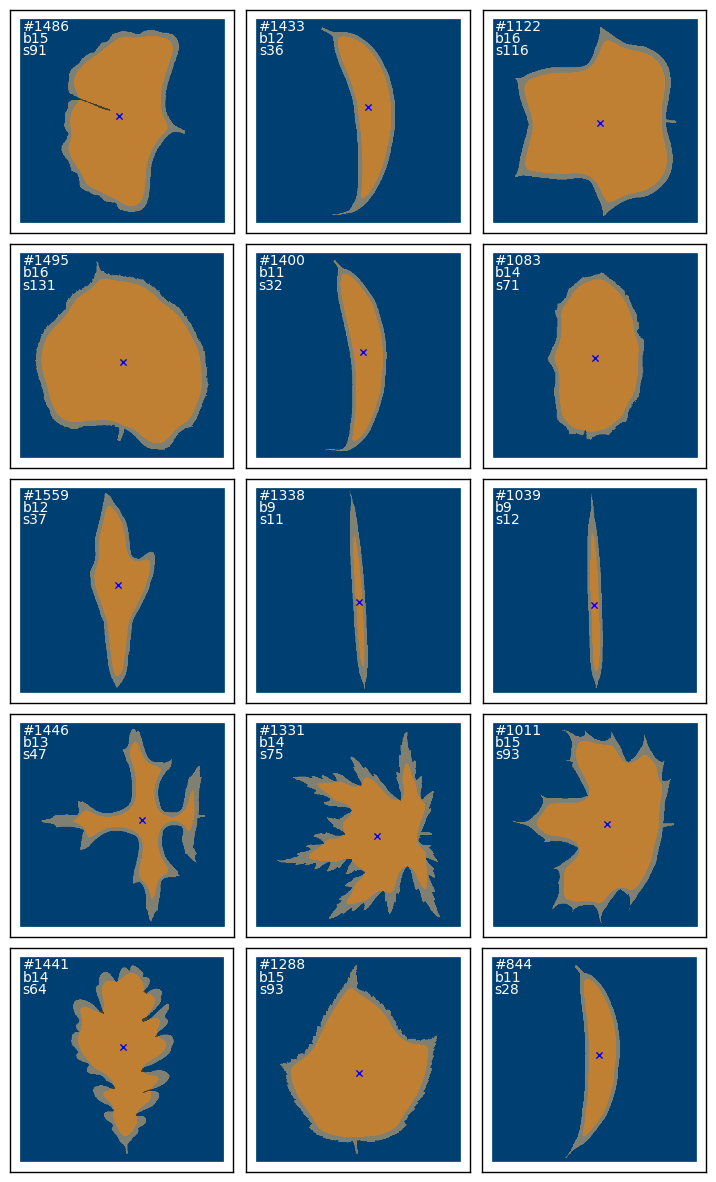

In [247]:
def gridplot(imgs, cols=3, rows=3):
    """convenience function that helped to find the brush-size formula"""

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(9,15))
    fig.subplots_adjust(wspace=.05, hspace=.05)
    
    for i in range(cols * rows):
        x = i % rows
        y = int(i / rows)

        number, img = next(imgs)
        size = int(np.count_nonzero(img)/1000)
        brush = int(5 * size/size**.75)
        blur = ndi.gaussian_filter(img, sigma=brush, mode='nearest') > 200
        cy, cx = ndi.center_of_mass(blur)
        
        ax[x, y].text(5, 25, '#'+str(number), color='w')
        ax[x, y].text(5, 55, 'b'+str(brush), color='w')
        ax[x, y].text(5, 85, 's'+str(size), color='w')
    
        ax[x, y].imshow(img, cmap='summer')
        ax[x, y].imshow(blur, alpha=.5)
        ax[x, y].scatter(cx, cy, marker='x')
        
        ax[x, y].xaxis.set_visible(False)
        ax[x, y].yaxis.set_visible(False)
    
    
testimages = [1486, 1495, 1559, 1446, 1441, 
             1433, 1400, 1338, 1331, 1288, 
             1122, 1083, 1039, 1011, 844]

gridplot(get_imgs(testimages), cols=3, rows=5)

## Now, turning all these into numerical features

The base of the metrics will be two contours:
- original leaf contour
- smoothed leaf contour

Then we build two time-series-like data structure from them
- describing the leaf edge:
  - for each point in the original contour, get the distance to the nearest point in the smoothed one
  - for this I will use [scipy.spatial.cKDTree](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html), which is a [KDTree](https://www.quora.com/What-is-a-kd-tree-and-what-is-it-used-for) implementation in C
- describing the leaf shape:
  - for each point on that contour, get the euclidean distance from the center

Then we derive meaningful statistics from them, like
- histogram of local (sliding window) frequency of the time series
- histogram of local (sliding window) amplitude of the time series
- some specialized stuff too, like
  - how clustered / spread the tips are
  - how pointy / round the tips (maxes) are
  - how pointy / round the gaps (mins) are
  - how often the line between the two contours cross, and how much
    - i.e. "how much that part leans away from central symmetry?"
    - tips usually leans towards the end of the leaf
  - probably the concaveness of the part, where the leaf is attached to the tree
  - and whatever comes to my mind

Also, I'm yet to come up good metrics for the shape, but:
- simple statistics work well here, like mean, SD, skewness / kurtosis
- if i want to avoid finding symmetry, I must do histograms or similar
- a measure of symmetry would be pretty good

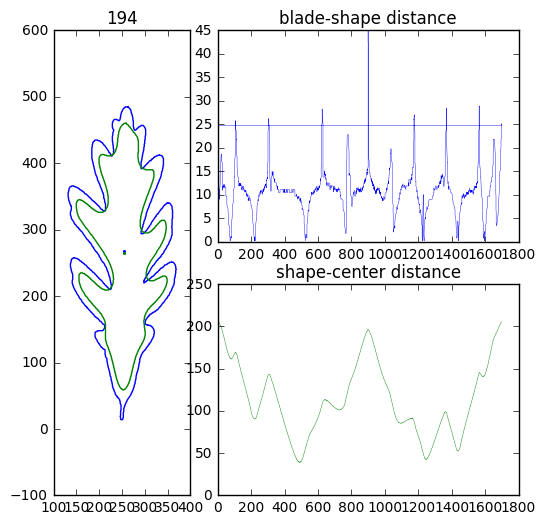

In [245]:
# for fun, work with a random leaf
# exploring solution before building it as function

title, img = list(get_imgs(1))[0]
blur = extract_shape(img)

blade = get_contour(img)
shape = get_contour(blur)
blade_y, blade_x = get_center(img)
shape_y, shape_x = get_center(blur)

blade_dist = sp.spatial.cKDTree(shape).query(blade)
shape_dist = metrics.pairwise.paired_distances(shape, [[shape_x, shape_y]] * len(shape))

ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2)
ax1.plot(*coords_to_cols(blade), *coords_to_cols(shape))
ax1.set_title(title)
ax1.scatter(blade_x, blade_y, marker='.', c='b', linewidth=0)
ax1.scatter(shape_x, shape_y, marker='.', c='g', linewidth=0)

ax2 = plt.subplot2grid((2,3), (0,1), colspan=2)
ax2.set_title('blade-shape distance')
ax2.plot(blade_dist[1], blade_dist[0], linewidth=.3)

ax3 = plt.subplot2grid((2,3), (1,1), colspan=2)
ax3.set_title('shape-center distance')
ax3.plot(range(len(shape_dist)), shape_dist, linewidth=.3, c='g')

plt.show()
